# Dino Diffusion

<a target="_blank" href="https://colab.research.google.com/github/madebyollin/dino-diffusion/blob/main/Dino_Diffusion.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Config

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import random
from collections import namedtuple
from pathlib import Path
from functools import lru_cache

import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm

th.backends.cudnn.benchmark = True

In [2]:
class Config:
    device = "cuda" if th.cuda.is_available() else "cpu"
    channels = 3
    hw = 64
    shape = (channels, hw, hw)
    dataset = "pokemon"

def show(x):
    if not isinstance(x, th.Tensor) or x.ndim == 4:
        x = th.cat(tuple(x), -1)
    display(TF.to_pil_image(x))

## Dataset

In [3]:
def get_dataset(name):
    if Path(name).exists():
        print(f"dataset '{name}' already exists; skipping...")
        return
    !git clone https://huggingface.co/datasets/huggan/{name} && (cd {name} && git lfs pull)
    import pyarrow.parquet as pq
    from io import BytesIO

    i = 0
    for table in Path(f"{name}/data").glob("*.parquet"):
        for row in tqdm(pq.read_table(table)[0]):
            Image.open(BytesIO(row["bytes"].as_py())).save(f"{name}/{i:04d}.jpg")
            i += 1
get_dataset(Config.dataset)

Cloning into 'pokemon'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), 1.77 KiB | 904.00 KiB/s, done.


100%|██████████| 7357/7357 [01:02<00:00, 117.64it/s]


In [4]:
Sample = namedtuple("Sample", ("im", "noisy_im", "noise_level"))

def alpha_blend(a, b, alpha):
    return alpha * a + (1 - alpha) * b

@lru_cache(maxsize=10000)
def load_im(path):
    return TF.pil_to_tensor(TF.center_crop(TF.resize(Image.open(path), Config.hw), Config.hw).convert("RGB"))

class Dataset(th.utils.data.Dataset):
    def __init__(self, p):
        self.ims = list(Path(p).rglob("*.jpg")) + list(Path(p).rglob("*.png"))
    def __len__(self):
        return len(self.ims)
    def __getitem__(self, i):
        im = load_im(self.ims[i]) / 255.0
        if random.random() < 0.5:
            im = TF.hflip(im)
        noise = th.rand_like(im)
        noise_level = th.rand(1, 1, 1)
        noisy_im = alpha_blend(noise, im, noise_level)
        return Sample(im, noisy_im, noise_level)

d_train = Dataset(Config.dataset)

Dataset has 7357 samples (not counting augmentation).
Here are some samples from the dataset:
Inputs


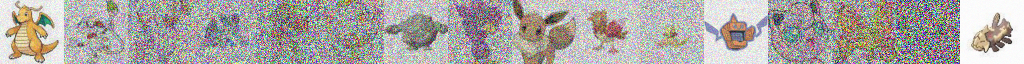

Target Outputs


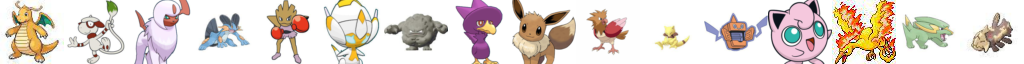

In [5]:
def demo_dataset(dataset, n=16):
    print(f"Dataset has {len(dataset)} samples (not counting augmentation).")
    print(f"Here are some samples from the dataset:")
    samples = random.choices(dataset, k=n)
    print(f"Inputs")
    show(s.noisy_im for s in samples)
    show(s.noise_level.expand(3, 16, Config.hw) for s in samples)
    print(f"Target Outputs")
    show(s.im for s in samples)
demo_dataset(d_train)

In [6]:
def to_device(ims):
    return Sample(*(x.to(Config.device) for x in ims))

In [7]:
# make sure the entire dataset loads
for batch in tqdm(th.utils.data.DataLoader(d_train, num_workers=2, batch_size=32)): to_device(batch)

100%|██████████| 230/230 [00:32<00:00,  7.06it/s]


## Model

In [8]:
Prediction = namedtuple("Prediction", ("denoised"))

def conv(n_in, n_out, **kwargs):
    return nn.Conv2d(n_in, n_out, 3, padding=1, **kwargs)

class Block(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.conv = nn.Sequential(conv(n_in, n_out), nn.ReLU(), conv(n_out, n_out, bias=False))
        self.skip = nn.Identity() if n_in == n_out else conv(n_in, n_out, bias=False)
    def forward(self, x):
        return self.conv(x) + self.skip(x)

class Pool(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.conv = nn.Sequential(nn.AdaptiveMaxPool2d(1), nn.Conv2d(n_in, n_in * 4, 1), nn.ReLU(), nn.Conv2d(n_in * 4, n_in, 1, bias=False))
    def forward(self, x):
        return self.conv(x) + x

def Blocks(n_in, n_out, n_b):
    return nn.Sequential(conv(n_in, n_out, bias=False), *[Block(n_out, n_out) for _ in range(n_b)], Pool(n_out))

def Enc(n_in, n_out, n_b):
    return nn.Sequential(nn.AvgPool2d(2), Blocks(n_in, n_out, n_b))

def Dec(n_in, n_out, n_b):
    return nn.Sequential(Blocks(n_in, n_out, n_b), nn.Upsample(scale_factor=2))

class UNet(nn.Module):
    def __init__(self, n_io=Config.channels, n_f=(64, 64, 64, 64, 64), n_b=(2, 2, 2, 2, 2)):
        super().__init__()
        self.cat = Blocks(n_io + 1, n_f[0], n_b[0])
        self.enc = nn.ModuleList([Enc(n_f[i], n_f[i+1], n_b[i+1]) for i in range(len(n_f) - 1)])
        self.dec = nn.ModuleList([Dec(n_f[i+1], n_f[i], n_b[i+1]) for i in range(len(n_f) - 1)])
        self.out = nn.Sequential(Blocks(n_f[0], n_f[0], n_b[0]), conv(n_f[0], n_f[0]), nn.ReLU(), conv(n_f[0], n_io))
        nn.init.constant_(self.out[-1].bias, 0.5)
    def forward(self, x, noise_level):
        skips = []
        x = self.cat(th.cat([x, noise_level.expand(x[:, :1].shape)], 1))
        for enc in self.enc:
            skips.append(x)
            x = enc(x)
        for dec in reversed(self.dec):
            x = dec(x) + skips.pop()
        return Prediction(self.out(x))

model = UNet().to(Config.device)

def weight_average(w_prev, w_new, n):
    alpha = min(0.95, n / 10)
    return alpha_blend(w_prev, w_new, alpha)
avg_model = th.optim.swa_utils.AveragedModel(model, avg_fn=weight_average)

Model has 2.2 million trainable parameters.
Here are some model outputs on random noise:


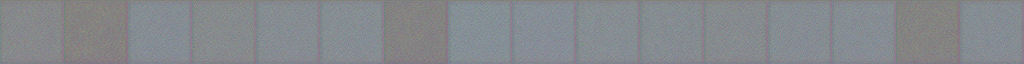

In [9]:
@th.no_grad()
def demo_model(model, n=16):
    model.eval()
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {n_parameters / 1e6:.1f} million trainable parameters.")
    x = th.rand(n, *Config.shape, device=Config.device)
    noise_level = th.rand(n, 1, 1, 1, device=Config.device)
    y = model(x, noise_level)
    print(f"Here are some model outputs on random noise:")
    show(y.denoised.clamp(0, 1))
    model.train()
demo_model(model)

## Image Generation

In [10]:
@th.no_grad()
def generate_images(model, n_images=16, n_steps=100, step_size=2.0):
    model.eval()
    x, prev = th.rand(n_images, *Config.shape, device=Config.device), None
    noise_levels = th.linspace(1, 0, n_steps + 1, device=Config.device)
    for nl_in, nl_out in zip(noise_levels, noise_levels[1:]):
        denoised = pred = model(x, nl_in.view(1, 1, 1, 1)).denoised
        if prev is not None: denoised = prev + step_size * (denoised - prev)
        x, prev = alpha_blend(x, denoised, nl_out / nl_in), pred
    model.train()
    return x.clamp(0, 1)

Here are some generated images (for an untrained model, they will be blank gray squares)


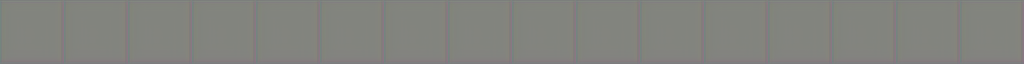

In [11]:
def demo_image_generation(model):
    print("Here are some generated images (for an untrained model, they will be blank gray squares)")
    show(generate_images(avg_model, n_images=16))
demo_image_generation(avg_model)

## Training

In [12]:
import os
import datetime
import time
from IPython.display import clear_output

class Visualizer:
    def __init__(self):
        self.smoothed_loss = None
        self.losses_since_last_vis = []
        self.avg_losses = []
        self.steps = []
        self.step = 0
        self.t_last_vis = 0
        self.t_last_save = 0
        self.t_start = None
        folder, idx = datetime.datetime.now().strftime("%Y_%m_%d") + "_training_logs", 0
        while Path(f"{folder}_{idx}").exists():
            idx += 1
        self.folder = Path(f"{folder}_{idx}")
        self.folder.mkdir()
    def __call__(self, model, t, x, y, loss, n_demo=16):
        self.losses_since_last_vis.append(loss)
        self.smoothed_loss = loss if self.smoothed_loss is None else 0.99 * self.smoothed_loss + 0.01 * loss
        self.step += 1
        if self.t_start is None:
            self.t_start = t
        if t > self.t_last_vis + 30:
            generated_images = generate_images(model, n_images=n_demo)
            clear_output(wait=True)
            print("Input Noisified Image, Noise Level")
            show(x.noisy_im[:n_demo])
            show(x.noise_level.expand(len(x.noise_level), 3, 16, Config.hw)[:n_demo])
            print("Predictions")
            show(y.denoised[:n_demo].clamp(0, 1))
            print("Targets")
            show(x.im[:n_demo])
            self.steps.append(self.step)
            self.avg_losses.append(sum(self.losses_since_last_vis) / len(self.losses_since_last_vis))
            self.losses_since_last_vis = []
            print("Generated Images (Averaged Model)")
            show(generated_images)
            plt.title("Losses")
            plt.plot(self.steps, self.avg_losses)
            plt.gcf().set_size_inches(16, 4)
            plt.ylim(0, 1.5 * self.avg_losses[-1])
            if t > self.t_last_save + 120:
                th.save(model.state_dict(), self.folder / "model.pth")
                th.save((self.steps, self.avg_losses), self.folder / "stats.pth")
                TF.to_pil_image(th.cat(tuple(generated_images), -1)).save(self.folder / f"generated_{self.step:07d}.jpg", quality=95)
                plt.gcf().savefig(self.folder / "stats.jpg")
                self.t_last_save = t
            plt.show()
            self.t_last_vis = t
        print(
            f"\r{self.step: 5d} Steps; {int(t - self.t_start): 3d} Seconds; "
            f"{60 * self.step / (t - self.t_start + 1):.1f} Steps / Min; "
            f"{len(x.im) * 60 * self.step / (t - self.t_start + 1):.1f} Images / Min; "
            f"Smoothed Loss {self.smoothed_loss:.5f}; "
        , end="")
        
class Looper(th.utils.data.Dataset):
    def __init__(self, dataset, n=1<<20):
        self.dataset = dataset
        self.n = n
    def __len__(self):
        return max(len(self.dataset), self.n)
    def __getitem__(self, i):
        return self.dataset[i % len(self.dataset)]
        
class Trainer:
    def __init__(self, model, avg_model, dataset, batch_size=16):
        self.model = model
        self.avg_model = avg_model
        self.last_avg_time = time.time()
        self.opt = th.optim.AdamW(model.parameters(), 3e-4, amsgrad=True)
        num_workers = min(8, len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else os.cpu_count())
        self.dataloader = th.utils.data.DataLoader(Looper(dataset), batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
        self.dl_iter = iter(self.dataloader)
        self.visualizer = Visualizer()

    def avg_model_step(self, t):
        if t > self.last_avg_time + 2:
            self.avg_model.update_parameters(self.model)
            self.last_avg_time = t

    def get_batch(self):
        try:
            batch = next(self.dl_iter)
        except StopIteration:
            self.dl_iter = iter(self.dataloader)
            batch = next(self.dl_iter)
        return to_device(batch)

    def train(self, n_seconds):
        self.model.train()
        start_time = time.time()
        while time.time() < start_time + n_seconds:
            self.train_step(time.time())

    def train_step(self, t):
        x = self.get_batch()
        y = self.model(x.noisy_im, x.noise_level)
        loss = F.mse_loss(y.denoised, x.im)
        self.opt.zero_grad(); loss.backward(); self.opt.step(); self.avg_model_step(t)
        self.visualizer(self.avg_model, t, x, y, loss.item())

trainer = Trainer(model, avg_model, d_train)

Input Noisified Image, Noise Level


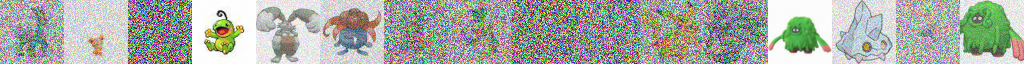

Predictions


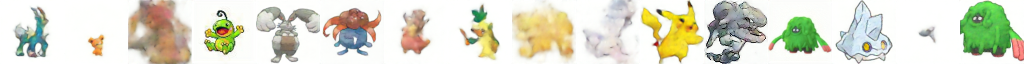

Targets


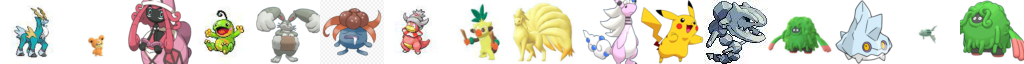

Generated Images (Averaged Model)


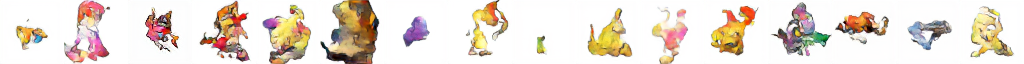

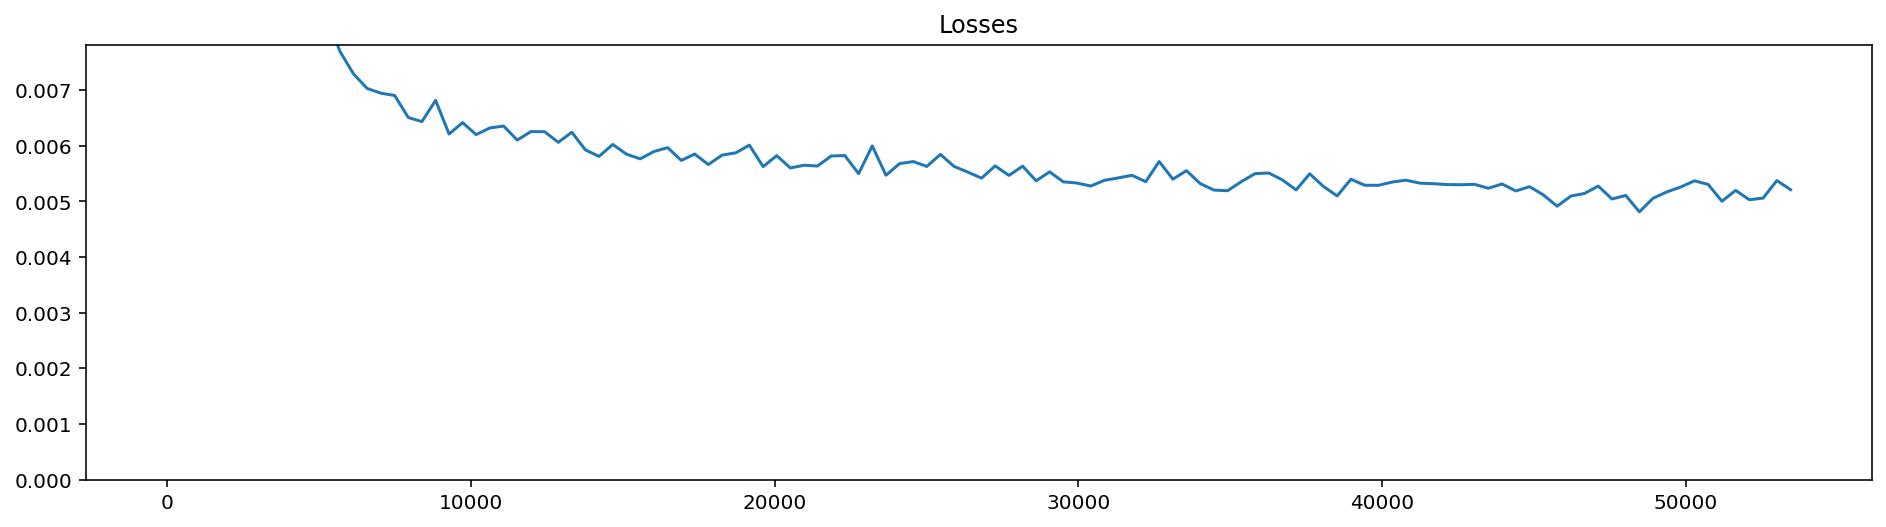

 53840 Steps;  3599 Seconds; 897.1 Steps / Min; 14353.4 Images / Min; Smoothed Loss 0.00499; 

In [13]:
trainer.train(n_seconds=60*60)

100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


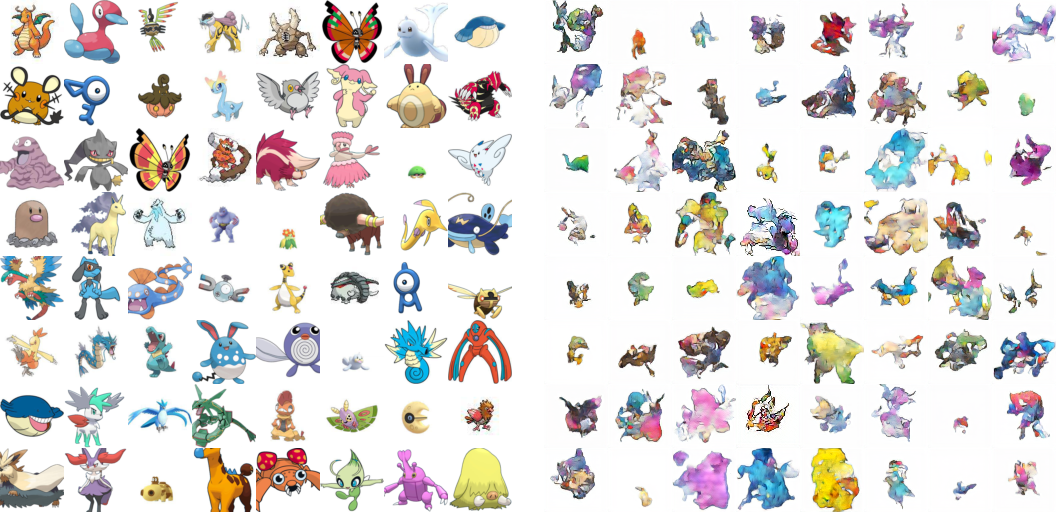

In [14]:
def demo_sample_grids(dataset, model, rows=8, cols=8):
    real_rows, fake_rows = [], []
    for i in tqdm(range(rows)):
        real_rows.append(th.cat([random.choice(dataset).im for _ in range(cols)], -1))
        fake_rows.append(th.cat(tuple(generate_images(model, n_images=cols)), -1))
    real_im = th.cat(real_rows, -2)
    padding = th.ones_like(real_im[..., :32])
    fake_im = th.cat(fake_rows, -2).cpu()
    return TF.to_pil_image(th.cat([real_im, padding, fake_im], -1))
demo_sample_grids(d_train, avg_model)